In [1]:
%run ./_setup.ipynb

In [2]:
# function for nonlinear least squares fitting
def fixed_line(t, slope):
    return slope*t

In [3]:
from scipy.stats import expon

# 3. Calculation of Inflow

To calculate the freshwater inflow to Galveston Bay, we use a control volume of the Bay and apply conservation of volume:

$\begin{align}
\partial V/\partial t &= Q_{fw} + Q_{ch} ~~~~~~~~(1) \\
\Rightarrow Q_{fw}(t) &= \partial V/\partial t - Q_{ch}(t)
\end{align}$

where $V(t)$ is the volume of Galveston Bay, $Q_{fw}(t)$ is the freshwater input to Galveston Bay, and $Q_{ch}(t)$ is the flux in Galveston Bay channel ($Q_{ch}$ is positive into the bay and negative on ebb tide out of the bay.

## 3.1 Bay Volume

Assuming that any change in x/y area of the bay due to flooding is limited (and therefore the surface area and bathymetry are constant), we have the following:

$\begin{align}
\partial V/\partial t &\approx A_s \partial \eta/\partial t, ~~~~~~~~(2)
\end{align}$

where $A_s$ is the surface area of Galveston Bay and $\eta$ is the sea level height.
We use the sea level at station 8771013 in the middle of the main bay to represent the sea level in both the main and east bays, and at stations 8771486 and 8771450 in the west bay to represent that area.

First find the areas and average depths of different Galveston regions. The bathymetry arrays of Galveston Bay are calculated in the `Process bathymetry` notebook.

In [18]:
bb = '/Volumes/Ingraham/Backups.backupdb/tahoma/2019-04-24-141656/Macintosh HD/Users/kthyng/Documents/papers/inprogress/harvey_inflow/code/data/bathy/'
bwest = np.load(bb + 'bathy_galv_west.npz')
bmain = np.load(bb + 'bathy_galv_main.npz')
bdxdy = np.load(bb + 'bathy_galv_clean.npz')


In [37]:
bathy = dict()
bathy['west'] = bwest['bathy']
bathy['dx'] = bdxdy['dx']
bathy['dy'] = bdxdy['dy']
bathy['main'] = bmain['bathy']
bathy['Dcs'] = 2277
bathy['Acs0'] = 25738

In [20]:
bathy['dx'], bathy['dy']

(array(44.97249721), array(51.32022929))

In [21]:
# Main bay surface area (includes East Bay, not West Bay)
Am = np.nansum(~np.isnan(bathy['main'])*bathy['dx']*bathy['dy'])
# Am = np.nansum(~np.isnan(bathy['main'])*bathy.attrs['dx']*bathy.attrs['dy'])

# # Full Galveston Bay
# Afull = np.nansum(~np.isnan(bathy)*dx*dy)

# West Bay
Aw = np.nansum(~np.isnan(bathy['west'])*bathy['dx']*bathy['dy'])
# Aw = np.nansum(~np.isnan(bathy['west'])*bathy.attrs['dx']*bathy.attrs['dy'])

# Average depth for main bays (includes East Bay, not West Bay)
Hm = -np.nanmean(bathy['main'])

# # Average depth for full galv bay
# Hfull = -np.nanmean(bathy)

# Average depth for west bay
Hw = -np.nanmean(bathy['west'])

Now calculate multiple options for the volume of the Bay, $V(t)$, and change in volume of the Bay, $dV/dt$. A rolling mean of 3 hours has been applied to $dV/dt$.

In [22]:
# Sea surface stations used
eta_main = '8771013'  # main bay and East bay together
eta_west = '8771486'  # West bay


V = (Am * (Hm + df['%s: Water Level [m, MHW]' % eta_main])) + (Aw * (Hw + df['%s: Water Level [m, MHW]' % eta_west]))
dVdt = (V.diff()/dt).rolling(center=True, window=4*3).mean()


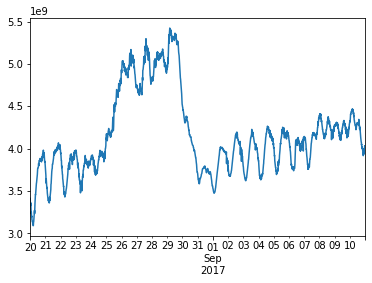

In [23]:
V['2017-8-20':'2017-9-10'].plot()

## 3.2 Channel Flux

### 3.2.1 ADCP data

We have data from an upward-facing ADCP from NOAA PORTS station `g06010` that spans much of the water column. We choose three ways to extrapolate the velocity data to be continuous from seabed from sea surface: piecewise linear, 2nd order polynomial, and 3rd order polynomial. This is done in the "Gather Data" notebook.

In [24]:
# Calculate the standared deviation and mean across along-channel velocity signals to use later
std_uch = df[['smean','smean_2nd','smean_3rd']].std(axis=1)
mean_uch = df[['smean','smean_2nd','smean_3rd']].mean(axis=1)

### 3.2.2 Salinity conservation

Conservation of salinity in Galveston Bay gives:

$
\begin{align}
d (S V)/d t &= S_{in}Q_{fw} + S_{ch} Q_{ch} \\
d (S V)/d t &=  S_{ch} Q_{ch} \\
\Rightarrow Q_{ch} &= \frac{1}{S_{ch}} \frac{d (S V)}{d t}  ~~~~~~~~~~~~~~~~~~ (4)
\end{align}
$

where the input salinity, $S_{in}$, is assumed to be fresh so $S_{in}=0$ and $S_{ch}$ is the channel salinity.

We have data from TWDB station BOLI to represent $S_{ch}$. Rayson et al 2017 finds that the volume-averaged salinity in the bay is reasonably represented by three TWDB stations: $S(t) = \frac{1}{3} TRIN + \frac{1}{3} MIDG + \frac{1}{3} BOLI$; we use this result.

The derivative term is calculated as follows, where the volume is approximated as the surface area times the average depth plus a representative sea surface height:

$
\begin{align}
    \frac{\partial (S V)}{\partial t} &= A_s \frac{\partial [S(H+\eta)]} {\partial t}.~~~~~~~~~~~~~~~~~~ (5)
\end{align}
$

We calculate this term for both of the bays (main and East together, and West Bay separately).

In [25]:
# Calculate volume averaged salinity
Sch = df['BOLI: Salinity']  # rename channel salinity

Solve for $Q_{ch}$ from conservation of salinity, Equation 4. Also solve for $Q_{fw}$, the freshwater flux, from Equation 1 using this $Q_{ch}$. It does not apply during the flooding when $S_{ch}=0$, but it does give results at other times.

The following is to find a range of values for $A_{eq}$ and metrics for when they should be valid.

In [26]:
## finding equivalent area and then final result for different inputs, Section 3.2.3 ##
def calc_harvey(smean, midgweight, date):
    
    # salinity
    S = ((1-0.33-midgweight)*df['TRIN: Salinity'] + midgweight*df['MIDG: Salinity'] + 0.33*Sch)  # volume averaged salinity

    dSVdt = (S*V).diff()/dt
    Qch = (dSVdt/Sch)
    Qr = Qch + dVdt

    enddate = date + pd.Timedelta('%i days' % ndays)

    Ut = df[smean][date:enddate].copy()
    Qt = Qch.loc[date:enddate].copy()
    Scht = Sch[date:enddate].copy()
    St = S[date:enddate].copy()
    
    indf = Ut > 0  # into the bay, flood tide
    inde = Ut < 0  # out of the bay, ebb tide

    # flood
    Uf = Ut[indf].copy()
    Qf = Qt[indf].copy()
    Stf = St[indf].copy()
    Schtf = Scht[indf].copy()
    ind = (~Uf.isnull()) & (~Qf.isnull())
    Uf = Uf[ind]; Qf = Qf[ind]; Stf = Stf[ind]; Schtf = Schtf[ind]
    # ebb
    Ue = Ut[inde].copy()
    Qe = Qt[inde].copy()
    Ste = St[inde].copy()
    Schte = Scht[inde].copy()
    ind = (~Ue.isnull()) & (~Qe.isnull())
    Ue = Ue[ind]; Qe = Qe[ind]; Schte = Schte[ind]; Ste = Ste[ind]

    npts = (len(Ue) + len(Uf))/len(Ut)  # ratio pts included

    Qcht = df[smean].copy()
    Uchf = df[smean][df[smean] > 0]; Uche = df[smean][df[smean] < 0]

    # may not work bc missing data
    # straight line
    if not Ue.empty and not Qe.empty and not Uf.empty and not Qf.empty:# and not (np.isnan(Ue).sum() == Ue.size):
        fite = curve_fit(fixed_line, Ue, Qe)
        fitf = curve_fit(fixed_line, Uf, Qf)

        ## Equation 3 after finding equivalent area for this loop ##
        Qcht[df[smean] > 0] = Uchf*fitf[0]
        Qcht[df[smean] < 0] = Uche*fite[0]

        # this is now the improved flux calculation which applies during the storm too
        Qchnew = Qcht.copy()

        # Section 3.3: inflow rate calculation
        Qrfin = (-Qchnew + dVdt)

        # Inflow volume calculation
        # save Harvey inflow
        harvey = Qrfin[date_outflow:date_endoutflow].sum()*dt/1000**3

        # save Harvey inflow WITHOUT dVdt term for comparison
        harvey_nodVdt = -Qchnew[date_outflow:date_endoutflow].sum()*dt/1000**3
        
    else:
        harvey = np.nan
        Qrfin = np.nan
        harvey_nodVdt = np.nan
            
    return npts, harvey, Qrfin, harvey_nodVdt

In [30]:
# Things to vary or set otherwise
smeans = ['smean', 'smean_2nd', 'smean_3rd']


# data time periods
ndays = 27  # 28 days total since first day is included
dates_use = dates[::4*24*7*2]



# weights for salinity
# exponential distribution between 0.33 and 0.67 for weight for MIDG — TRIN is remainder with BOLI as 0.33
loc = 0.33; scale = .0451
pdf = expon(loc=loc, scale=scale)
midgweights = pdf.rvs(10)


# difference in cumulative sums after ndays days, in km^3
nrows = len(smeans)*len(dates_use)*len(midgweights)


Run through all the combinations of inputs to get a best estimate for inflow and uncertainty.

In [31]:
%%time
harv = pd.DataFrame(index=np.arange(nrows))  # save overall results
ts = pd.DataFrame(index=pd.date_range(pd.Timestamp('2017-8-1'), pd.Timestamp('2017-10-1'), freq='15T'))  # save time series

i = 0
for smean in smeans:
    for date in dates_use:
        for midgweight in midgweights:

            harv.loc[i,'npts'], harv.loc[i,'harvey inflow [km^3]'], \
                ts.loc[:,i], harv.loc[i,'harvey inflow - no dVdt [km^3]'] = calc_harvey(smean, midgweight, date)
            harv.loc[i,'smean'] = smean
            harv.loc[i,'midgweight'] = midgweight
            harv.loc[i,'date'] = date
            i += 1

CPU times: user 5min 34s, sys: 4min 44s, total: 10min 19s
Wall time: 10min 24s


Median of Harvey inflow estimates: 21.9
Mean of Harvey inflow estimates: 23.2
Standard deviation of Harvey inflow estimates: 6.6
Number of valid Harvey inflow estimates: 540
Number of total Harvey inflow estimates: 3930


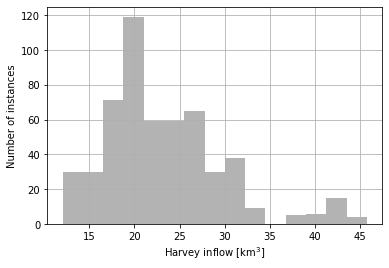

In [32]:
nptsmin = 0.8

inpts = harv['npts'] > nptsmin
iharvey = (harv['date'] > pd.Timestamp('2017-7-25')) & (harv['date'] < pd.Timestamp('2017-9-24'))
ibad2018 = harv['date'] > pd.Timestamp('2018-5-1')
iuse = inpts & ~iharvey & ~ibad2018
key = 'harvey inflow [km^3]'
ax = harv[key][iuse].hist(bins=15, color='0.7')
ax.set_xlabel('Harvey inflow [km$^3$]')
ax.set_ylabel('Number of instances')

print('Median of Harvey inflow estimates: %2.1f' % harv[key][iuse].median())
print('Mean of Harvey inflow estimates: %2.1f' % harv[key][iuse].mean())  # for reference
print('Standard deviation of Harvey inflow estimates: %2.1f' % harv[key][iuse].std())
print('Number of valid Harvey inflow estimates: %2i' % len(harv[iuse]))
print('Number of total Harvey inflow estimates: %2i' % len(harv))

Vfw = harv[key][iuse].median()

plt.savefig('../figures/histogram.pdf', bbox_inches='tight')

Read in TWDB inflow estimates

In [34]:
convert = 0.0142764  # 1 acre-foot per day = 0.0142764 m^3/s

fname = '%s%s' % (baset, 'updated_daily_gauged_modelled_1Aug2017-30Sep2017.txt')
twdb = pd.read_table(fname, parse_dates=True, index_col=0)*convert
twdb['inflow'] = twdb.sum(axis=1)

In [33]:
df.loc['2017-8-20':'2017-9-10','g06010: Along [cm/s] (water)'].min()

-221.45666666666668

In [34]:
2.2*25738

56623.600000000006

In [38]:
bathy.attrs['Dcs']

2277.176007581218

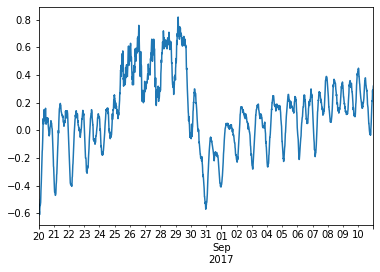

In [40]:
df.loc['2017-8-20':'2017-9-10','8771341: Water Level [m, MHW]'].plot()

In [46]:
Acs

2014-01-01 00:00:00             NaN
2014-01-01 00:15:00    25703.419297
2014-01-01 00:30:00    25714.805177
                           ...     
2018-12-31 23:30:00    25783.120457
2018-12-31 23:45:00    25771.734577
2019-01-01 00:00:00    25771.734577
Name: 8771341: Water Level [m, MHW], Length: 175297, dtype: float64

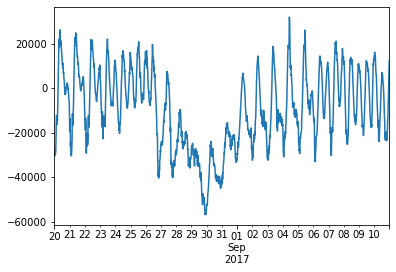

In [49]:
(df['g06010: Along [cm/s] (water)']/100*Acs)['2017-8-20':'2017-9-10'].plot()

/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


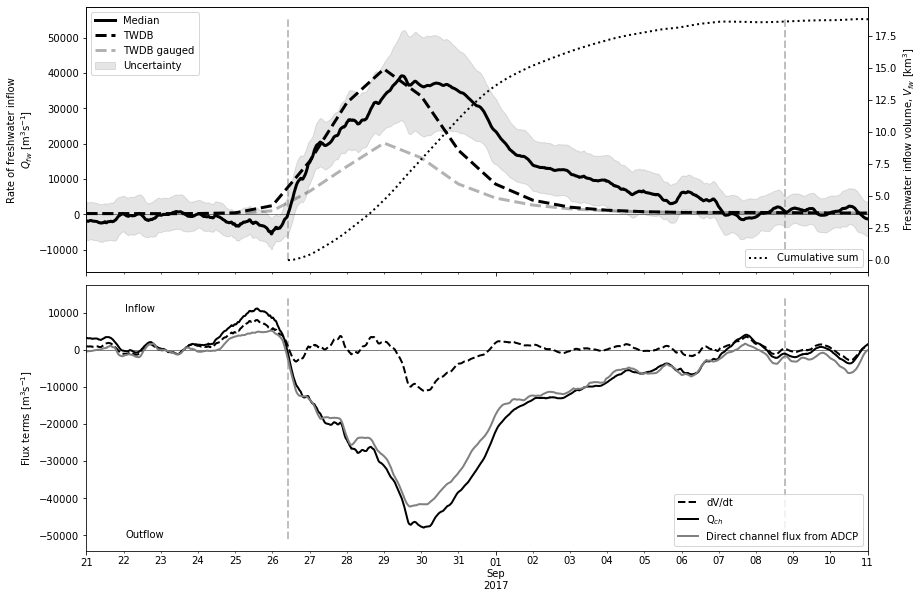

In [42]:
dstart = '2017-8-21'; dend = '2017-9-11'
tsmed = ts.loc[:,iuse].median(axis=1).rolling(window=24*4*1, center=True).mean()
tsstd = ts.loc[:,iuse].std(axis=1).rolling(window=24*4*1, center=True).mean()

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14,10))
fig.subplots_adjust(hspace=0.05)

## plot freshwater inflow
ax = axes[0]
tsmed[dstart:dend].plot(color='k', lw=3, label='Median', ax=ax)
ax.fill_between(df[dstart:dend].index, (tsmed - tsstd)[dstart:dend], (tsmed + tsstd)[dstart:dend], 
                color='k', alpha=0.1, label='Uncertainty')
twdb['inflow'][dstart:dend].plot(color='k', lw=3, linestyle='--', label='TWDB', ax=ax)
twdb['gauged'][dstart:dend].plot(color='k', lw=3, alpha=0.3, linestyle='--', label='TWDB gauged', ax=ax)
ax2 = ax.twinx()
(tsmed[date_outflow:dend].cumsum()*dt/1000**3).plot(color='k', lw=2, ax=ax2, linestyle=':', label='Cumulative sum')
ax2.set_ylabel('Freshwater inflow volume, $V_{fw}$ [km$^3$]')
ax2.legend(loc='lower right')

ax.set_ylabel('Rate of freshwater inflow\n$Q_{fw}$ [m$^3$s$^{-1}$]')
ax.set_xlabel('');
ax.legend(loc='upper left')


# plot individual signals in calculation
ax = axes[1]
dVdt.rolling(window=24*4*1, center=True).mean()[dstart:dend].plot(ax=ax, linestyle='--', color='k', 
                                                                  linewidth=2, label='dV/dt')
# Calculate channel flux using our median time series
Qch = dVdt - tsmed
Qch.rolling(window=24*4*1, center=True).mean()[dstart:dend].plot(color='k', ax=ax, linewidth=2, label='Q$_{ch}$')

# Calculate channel flux using NOAA PORTS signal and cross-sectional area of the entrance channel calculated in
# 0_process_bathymetry notebook
Acs = bathy.attrs['Acs0'] + bathy.attrs['Dcs']*df['8771341: Water Level [m, MHW]']
Qch_adcp = df['g06010: Along [cm/s] (water)']/100*Acs
Qch_adcp.rolling(window=24*4*1, center=True).mean()[dstart:dend].plot(ax=ax, color='0.5', lw=2, label='Direct channel flux from ADCP')
ax.set_ylabel('Flux terms [m$^3$s$^{-1}$]')
ax.text(0.05, 0.90, 'Inflow', transform=ax.transAxes)
ax.text(0.05, 0.05, 'Outflow', transform=ax.transAxes)
ax.legend(loc='lower right')


for ax in axes:
    ylims = ax.get_ylim()
    ax.vlines(date_outflow, *ylims, linewidth=2, alpha=0.5, color='0.5', linestyle='--')
    ax.vlines(date_endoutflow, *ylims, linewidth=2, alpha=0.5, color='0.5', linestyle='--')
    ax.hlines(0, dstart, dend, lw=1, alpha=0.5)


ax.set_xlim(dstart, dend)

plt.savefig('../figures/inflow_comp.pdf', bbox_inches='tight')

(25054560, 25084800)

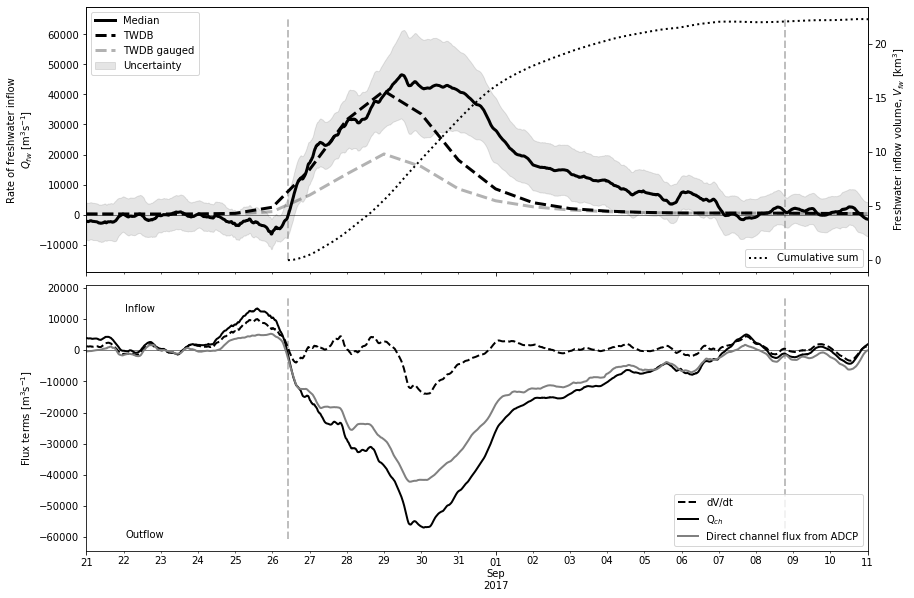

In [38]:
dstart = '2017-8-21'; dend = '2017-9-11'
tsmed = ts.loc[:,iuse].median(axis=1).rolling(window=24*4*1, center=True).mean()
tsstd = ts.loc[:,iuse].std(axis=1).rolling(window=24*4*1, center=True).mean()

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14,10))
fig.subplots_adjust(hspace=0.05)

## plot freshwater inflow
ax = axes[0]
tsmed[dstart:dend].plot(color='k', lw=3, label='Median', ax=ax)
ax.fill_between(df[dstart:dend].index, (tsmed - tsstd)[dstart:dend], (tsmed + tsstd)[dstart:dend], 
                color='k', alpha=0.1, label='Uncertainty')
twdb['inflow'][dstart:dend].plot(color='k', lw=3, linestyle='--', label='TWDB', ax=ax)
twdb['gauged'][dstart:dend].plot(color='k', lw=3, alpha=0.3, linestyle='--', label='TWDB gauged', ax=ax)
ax2 = ax.twinx()
(tsmed[date_outflow:dend].cumsum()*dt/1000**3).plot(color='k', lw=2, ax=ax2, linestyle=':', label='Cumulative sum')
ax2.set_ylabel('Freshwater inflow volume, $V_{fw}$ [km$^3$]')
ax2.legend(loc='lower right')

ax.set_ylabel('Rate of freshwater inflow\n$Q_{fw}$ [m$^3$s$^{-1}$]')
ax.set_xlabel('');
ax.legend(loc='upper left')


# plot individual signals in calculation
ax = axes[1]
dVdt.rolling(window=24*4*1, center=True).mean()[dstart:dend].plot(ax=ax, linestyle='--', color='k', 
                                                                  linewidth=2, label='dV/dt')
# Calculate channel flux using our median time series
Qch = dVdt - tsmed
Qch.rolling(window=24*4*1, center=True).mean()[dstart:dend].plot(color='k', ax=ax, linewidth=2, label='Q$_{ch}$')

# Calculate channel flux using NOAA PORTS signal and cross-sectional area of the entrance channel calculated in
# 0_process_bathymetry notebook
Acs = bathy['Acs0'] + bathy['Dcs']*df['8771341: Water Level [m, MHW]']
Qch_adcp = df['g06010: Along [cm/s] (water)']/100*Acs
Qch_adcp.rolling(window=24*4*1, center=True).mean()[dstart:dend].plot(ax=ax, color='0.5', lw=2, label='Direct channel flux from ADCP')
ax.set_ylabel('Flux terms [m$^3$s$^{-1}$]')
ax.text(0.05, 0.90, 'Inflow', transform=ax.transAxes)
ax.text(0.05, 0.05, 'Outflow', transform=ax.transAxes)
ax.legend(loc='lower right')


for ax in axes:
    ylims = ax.get_ylim()
    ax.vlines(date_outflow, *ylims, linewidth=2, alpha=0.5, color='0.5', linestyle='--')
    ax.vlines(date_endoutflow, *ylims, linewidth=2, alpha=0.5, color='0.5', linestyle='--')
    ax.hlines(0, dstart, dend, lw=1, alpha=0.5)


ax.set_xlim(dstart, dend)

# plt.savefig('../figures/inflow_comp.pdf', bbox_inches='tight')

Verify that integrating the median time series gives the median inflow number.

MEDIAN CHANGED???

In [39]:
# median time series
tsmed[date_outflow:date_endoutflow].sum()*dt/1000**3

22.078280690420534

In [40]:
1679/1344

1.2492559523809523

In [44]:
1.25*18.5

23.125

## 4. Discussion

### 4.1 Comparisons

### TWDB inflow estimate

In [16]:
# integral over flooding time period
VTWDB = (twdb['inflow'][date_outflow:date_endoutflow]*86400).sum()/1000**3
print('TWDB freshwater volume inflow: %2.1f km^3' % VTWDB)

VTWDB_gauged = (twdb['gauged'][date_outflow:date_endoutflow]*86400).sum()/1000**3
VTWDB_ungauged = (twdb['modelled'][date_outflow:date_endoutflow]*86400).sum()/1000**3
print('TWDB ungauged freshwater volume inflow: %2.1f km^3' % (VTWDB_ungauged))
print('TWDB gauged freshwater volume inflow: %2.1f km^3' % (VTWDB_gauged))


per = ((Vfw - VTWDB)/VTWDB)*100
print('The present study predicts an inflow that is %2.0f percent more than the TWDB model.' % per)

per = ((Vfw - VTWDB)/Vfw)*100
print('The TWDB model inflow prediction is %2.0f percent lower than the prediction in the present study.' % per)

TWDB freshwater volume inflow: 13.6 km^3
TWDB ungauged freshwater volume inflow: 7.0 km^3
TWDB gauged freshwater volume inflow: 6.6 km^3
The present study predicts an inflow that is 36 percent more than the TWDB model.
The TWDB model inflow prediction is 27 percent lower than the prediction in the present study.


### Galveston Bay volume

In [17]:
Vall = (np.nansum(bathy['main']*bathy.attrs['dx']*bathy.attrs['dy']) + np.nansum(bathy['west']*bathy.attrs['dx']*bathy.attrs['dy']))/1000**3

print('The flood water could fill the bay approximately %1.0f times' % abs(Vfw/Vall))

The flood water could fill the bay approximately 6 times


In [45]:
Vall = (np.nansum(bathy['main']*bathy['dx']*bathy['dy']) + np.nansum(bathy['west']*bathy['dx']*bathy['dy']))/1000**3

print('The flood water could fill the bay approximately %1.0f times' % abs(Vfw/Vall))

The flood water could fill the bay approximately 6 times


In [46]:
Vall

-3.6709412355745945

In [19]:
# A = np.nansum(~np.isnan(bathymain)*dx*dy) + np.nansum(~np.isnan(bathywest)*dx*dy)  # m^2
Am = np.nansum(~np.isnan(bathy['main'])*bathy.attrs['dx']*bathy.attrs['dy'])
Aw = np.nansum(~np.isnan(bathy['west'])*bathy.attrs['dx']*bathy.attrs['dy'])
A = Am + Aw

# average depth
# H = -np.nanmean(bathymain + bathywest)  # m
Hm = -np.nanmean(bathy['main'])
# Average depth for west bay
Hw = -np.nanmean(bathy['west'])
# H = Hm + Hw

# average volume
Vall = (Am*Hm + Aw*Hw)/1000**3  # km^3
Vall

3.1850750884526766

In [20]:
Vfw/5.5

3.365379229380494

In [21]:
bathy.attrs['dx']

44.98230247902091

In [22]:
11/Vall

3.4536077469193507

In [24]:
14/3.8

3.68421052631579